In [1]:
import sys 
from importlib import reload
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

sys.path.append( "../../utils")
import df_one_hot_encode


C:\Users\mrestrepo\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# https://www.kaggle.com/c/home-credit-default-risk/data
DATA_DIR = r"C:\_DATA\experimentation\HC_Default_Risk/"
app_fn = DATA_DIR + "application_train.csv"

df0 = pd.read_csv( app_fn )
#columns to lowercase 
df0.columns = [ col.lower() for col in df0.columns ]
#desc = df0.describe().transpose()
df0 = df0.set_index( 'sk_id_curr')

df0.rename( columns={ "days_birth" : "age",
                      "name_education_type" : "education",
                      "name_housing_type" : "housing",
                      "name_income_type"  : "income",
                      "name_family_status" : "fam_status",
                      "code_gender" : "gender"}, inplace=True) 

df0['education'] = ( df0['education'].replace('Secondary / secondary special', 'Secondary')
                                     .replace( 'Higher education', 'Higher') ) 

In [19]:
df1 = df0.copy()
del df1['organization_type'] # dropped because of too many values
del df1['ext_source_1']
del df1['ext_source_2']
del df1['ext_source_3']
df1['flag_own_car'] = df0['flag_own_car'] == 'Y'
df1['flag_own_realty'] = df0['flag_own_realty'] == 'Y'
cat_vars_0  = df1.dtypes[ df1.dtypes == 'object' ]
# cat_vars_0

In [4]:
reload( df_one_hot_encode )

oh_enc = df_one_hot_encode.DfOneHotEncoder( cat_vars_0.index )

oh_enc.fit( df1 )
df1 = oh_enc.transform( df1, drop_old=True )

In [5]:
# Convert flag columns to bool
for col in df1.columns :
    if col.startswith( 'flag_' ) or col.startswith( 'reg_') : 
        df1[col] = (df1[col] == 1)
        #print( df1[col].value_counts() )

In [6]:
# For float64 columns impute  NaNs with median 
for col in df1.select_dtypes('float64').columns : 
    if df1[col].isnull().sum() > 0 :  
        median = df1[col].median() 
        df1[col] = df1[col].fillna(  median )

In [7]:
pd.set_option( 'display.max_columns', 200 )
pd.set_option( 'display.max_rows', 150 )

In [8]:
train, test = train_test_split( df1, train_size = 0.8, test_size = 0.2 )
Y_train = train['target']
Y_test  = test['target']

X_train = train.loc[ : , train.columns != 'target']
X_test  = test .loc[ : , test.columns != 'target']

In [21]:
X_train.to_hdf( DATA_DIR + "preprocessed.hd5", "/train")
Y_train.to_hdf( DATA_DIR + "preprocessed.hd5", "/y_train")

In [9]:
na_cnts = X_train.isnull().sum()
na_cnts[na_cnts > 0], Y_train.isnull().sum()

(Series([], dtype: int64), 0)

In [10]:
Y_test.mean()

0.07944327918963302

In [11]:
rfc = RandomForestClassifier( n_estimators=100, min_samples_split=50, min_samples_leaf=10, max_depth=12)
rfc.fit( X_train, Y_train )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
def roc_auc_scorer( clf, X, y ) :
    y_pred = clf.predict_proba(X)[:,1]
    return roc_auc_score( y, y_pred )

roc_auc_scorer( rfc, X_train, Y_train ), roc_auc_scorer( rfc, X_test, Y_test )

(0.789472714244152, 0.6806283498681719)

In [13]:
from sklearn.externals import joblib

joblib.dump( rfc, DATA_DIR + "/rfc.pkl" )

['C:\\_DATA\\experimentation\\HC_Default_Risk//rfc.pkl']

In [14]:
feat_imp = pd.DataFrame( {"column" : X_train.columns,
                          "importance" : rfc.feature_importances_ } 
                       ).sort_values( "importance", ascending = False)
feat_imp['cumsum'] = feat_imp['importance'].cumsum()
feat_imp['rank'] = len(feat_imp) - feat_imp['importance'].rank()
feat_imp

,column,importance,cumsum,rank
9,days_employed,0.061927,0.061927,0.0
8,age,0.060746,0.122673,1.0
76,days_last_phone_change,0.044636,0.167309,2.0
11,days_id_publish,0.039101,0.206409,3.0
6,amt_goods_price,0.038475,0.244884,4.0
4,amt_credit,0.031713,0.276597,5.0
10,days_registration,0.028974,0.305571,6.0
5,amt_annuity,0.027270,0.332840,7.0
21,region_rating_client_w_city,0.023340,0.356181,8.0
124,education__higher,0.022574,0.378755,9.0


In [17]:
cols_inc = [ col for col in  list(feat_imp['column'].iloc[:90]) + ["target"]
                 if not col.startswith("ext_source_")  ]
train, test = train_test_split( df1[ cols_inc  ], train_size = 0.8, test_size = 0.2 )
y_train = train["target"]
y_test  = test["target"]
X_train = train.loc[ : , train.columns != 'target'].copy()
X_test  = test .loc[ : , test .columns != 'target'].copy()
train.columns

Index(['days_employed', 'age', 'days_last_phone_change', 'days_id_publish',
       'amt_goods_price', 'amt_credit', 'days_registration', 'amt_annuity',
       'region_rating_client_w_city', 'education__higher', 'gender__f',
       'region_population_relative', 'gender__m', 'education__secondary',
       'income__working', 'own_car_age', 'amt_income_total',
       'region_rating_client', 'flag_document_3', 'livingarea_avg',
       'hour_appr_process_start', 'livingarea_medi', 'totalarea_mode',
       'livingarea_mode', 'flag_own_car', 'years_beginexpluatation_avg',
       'apartments_medi', 'apartments_mode', 'years_beginexpluatation_medi',
       'apartments_avg', 'def_30_cnt_social_circle', 'flag_emp_phone',
       'landarea_avg', 'landarea_mode', 'amt_req_credit_bureau_year',
       'reg_city_not_live_city', 'basementarea_avg',
       'years_beginexpluatation_mode', 'landarea_medi', 'fam_status__married',
       'basementarea_medi', 'basementarea_mode', 'obs_30_cnt_social_circle',
  

In [12]:
for (obj, fname) in [ (Y_train, "y_train"), (Y_test, "y_test"),
                      (X_train, "x_train"), (X_test, "x_test") ] : 
     obj.to_pickle( DATA_DIR + "/" + fname + ".pkl")

In [18]:
rfc1 = RandomForestClassifier( n_estimators=500, min_samples_split=50, min_samples_leaf=10, max_depth=12)
rfc1.fit( X_train, y_train )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
joblib.dump( rfc1, DATA_DIR + './rfc1.pkl')

In [209]:
(X_test.columns == X_train.columns).all(), Y_train.mean(), Y_test.mean()

(True, 0.08044453838899548, 0.08186592523941921)

In [ ]:
roc_auc_scorer( rfc1, X_train, y_train ), roc_auc_scorer( rfc1, X_test, y_test )

In [ ]:
from tcxp import rf_explain, as_pyplot_figure

In [ ]:
tc_exps, p0  = rf_explain( rfc1, X_train[:1000]) 

In [ ]:
_ = as_pyplot_figure( tc_exps[1][:20], p0, X_train.columns[:20], 'Case 1')

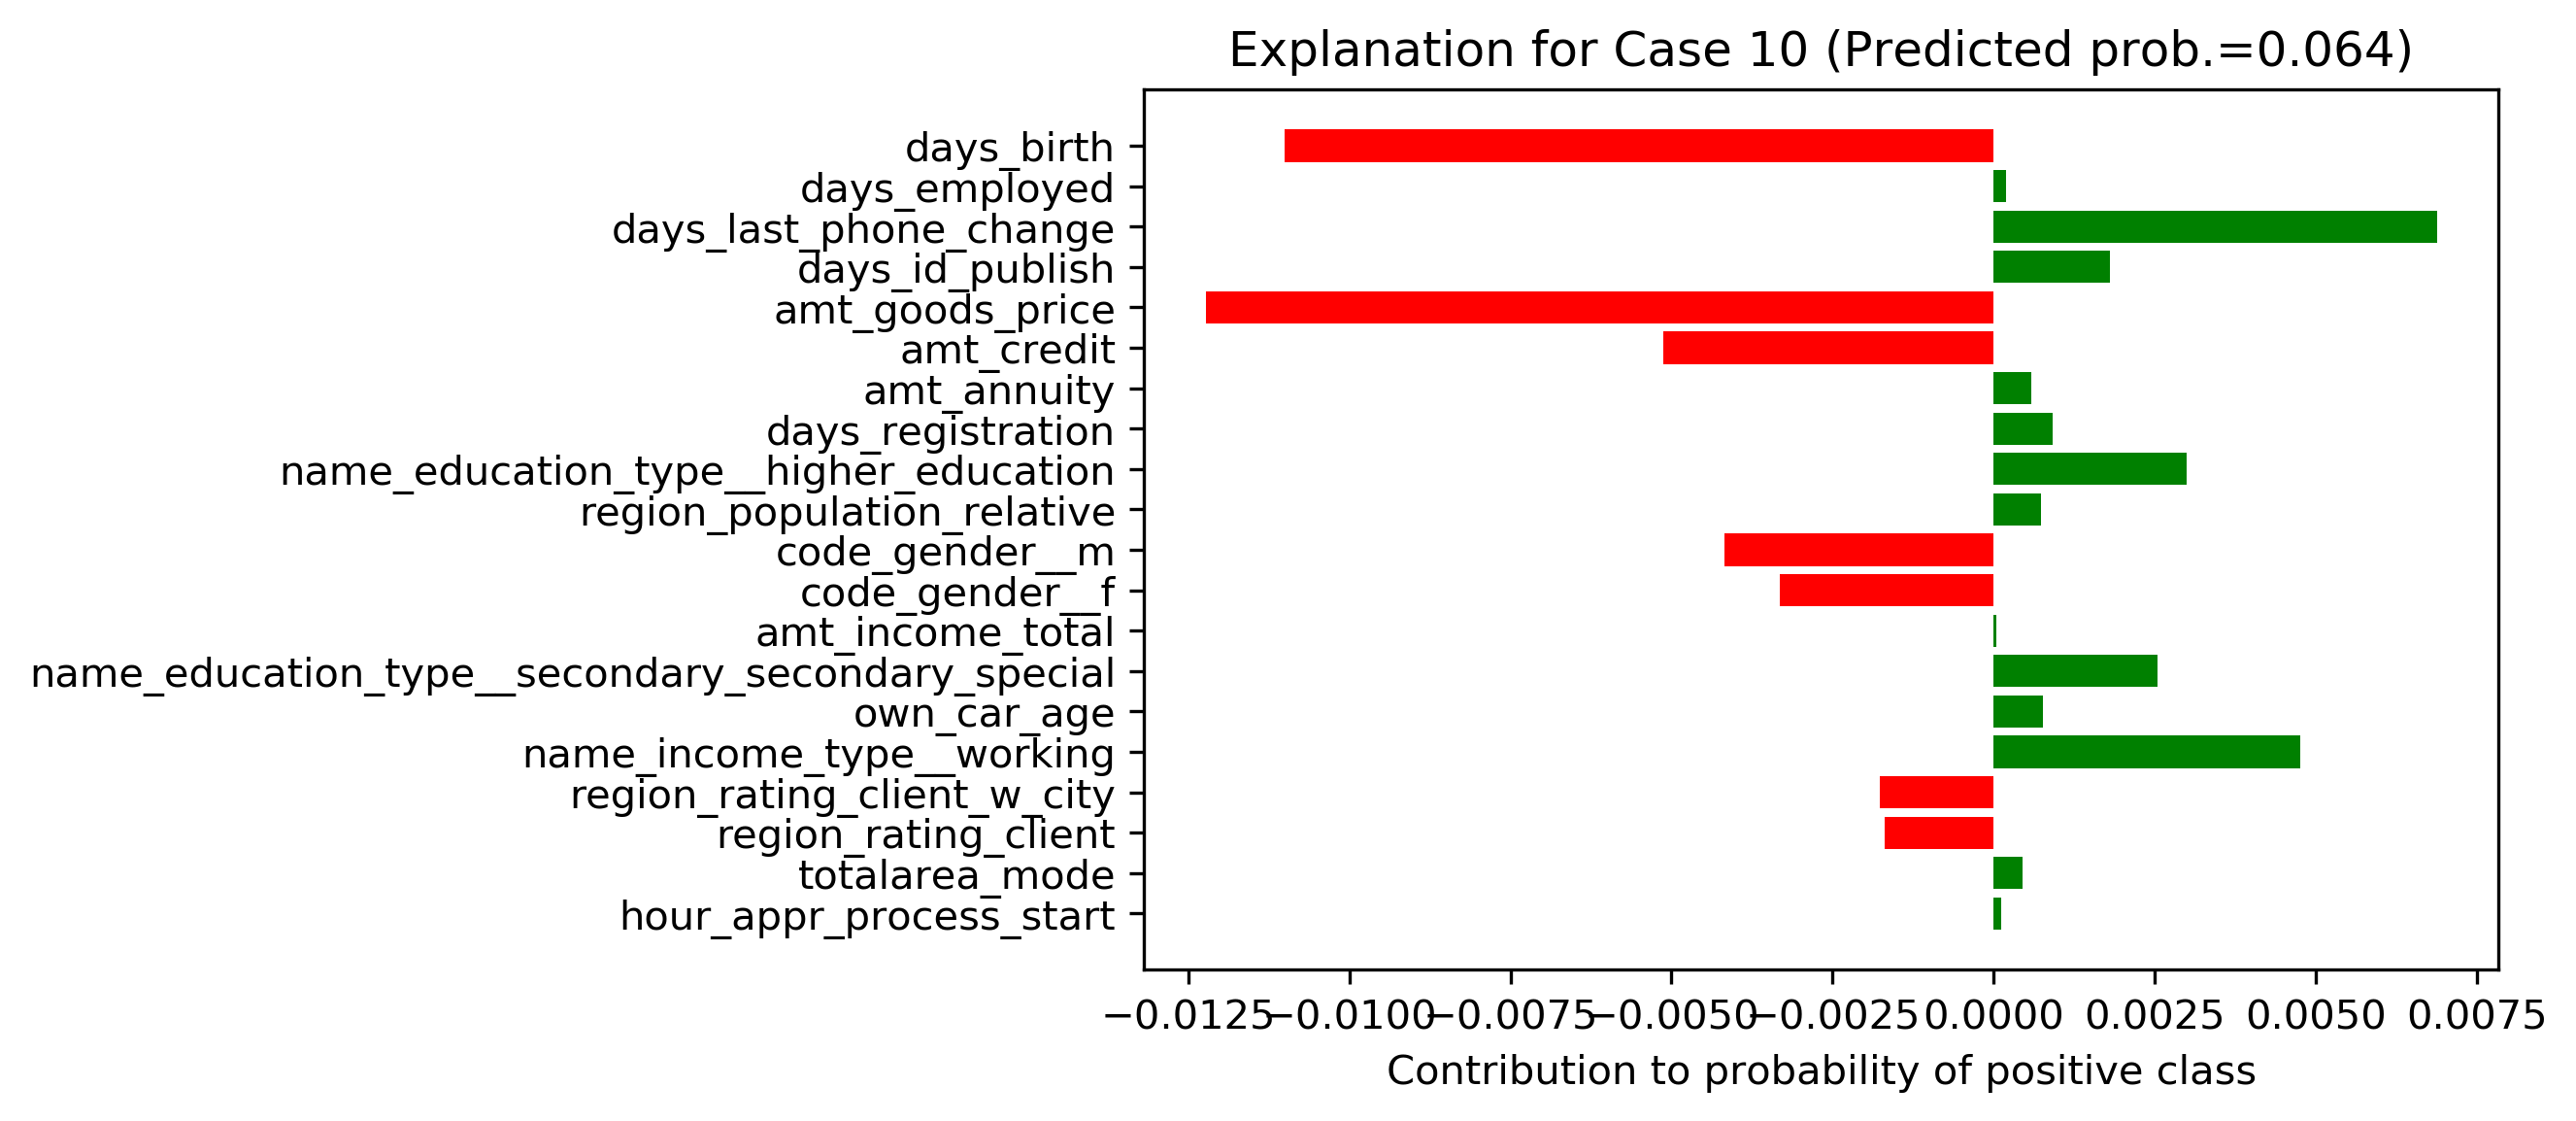

In [246]:
i = 10
_ = as_pyplot_figure( tc_exps[i][:20], p0, X_train.columns[:20], f'Case {i}')

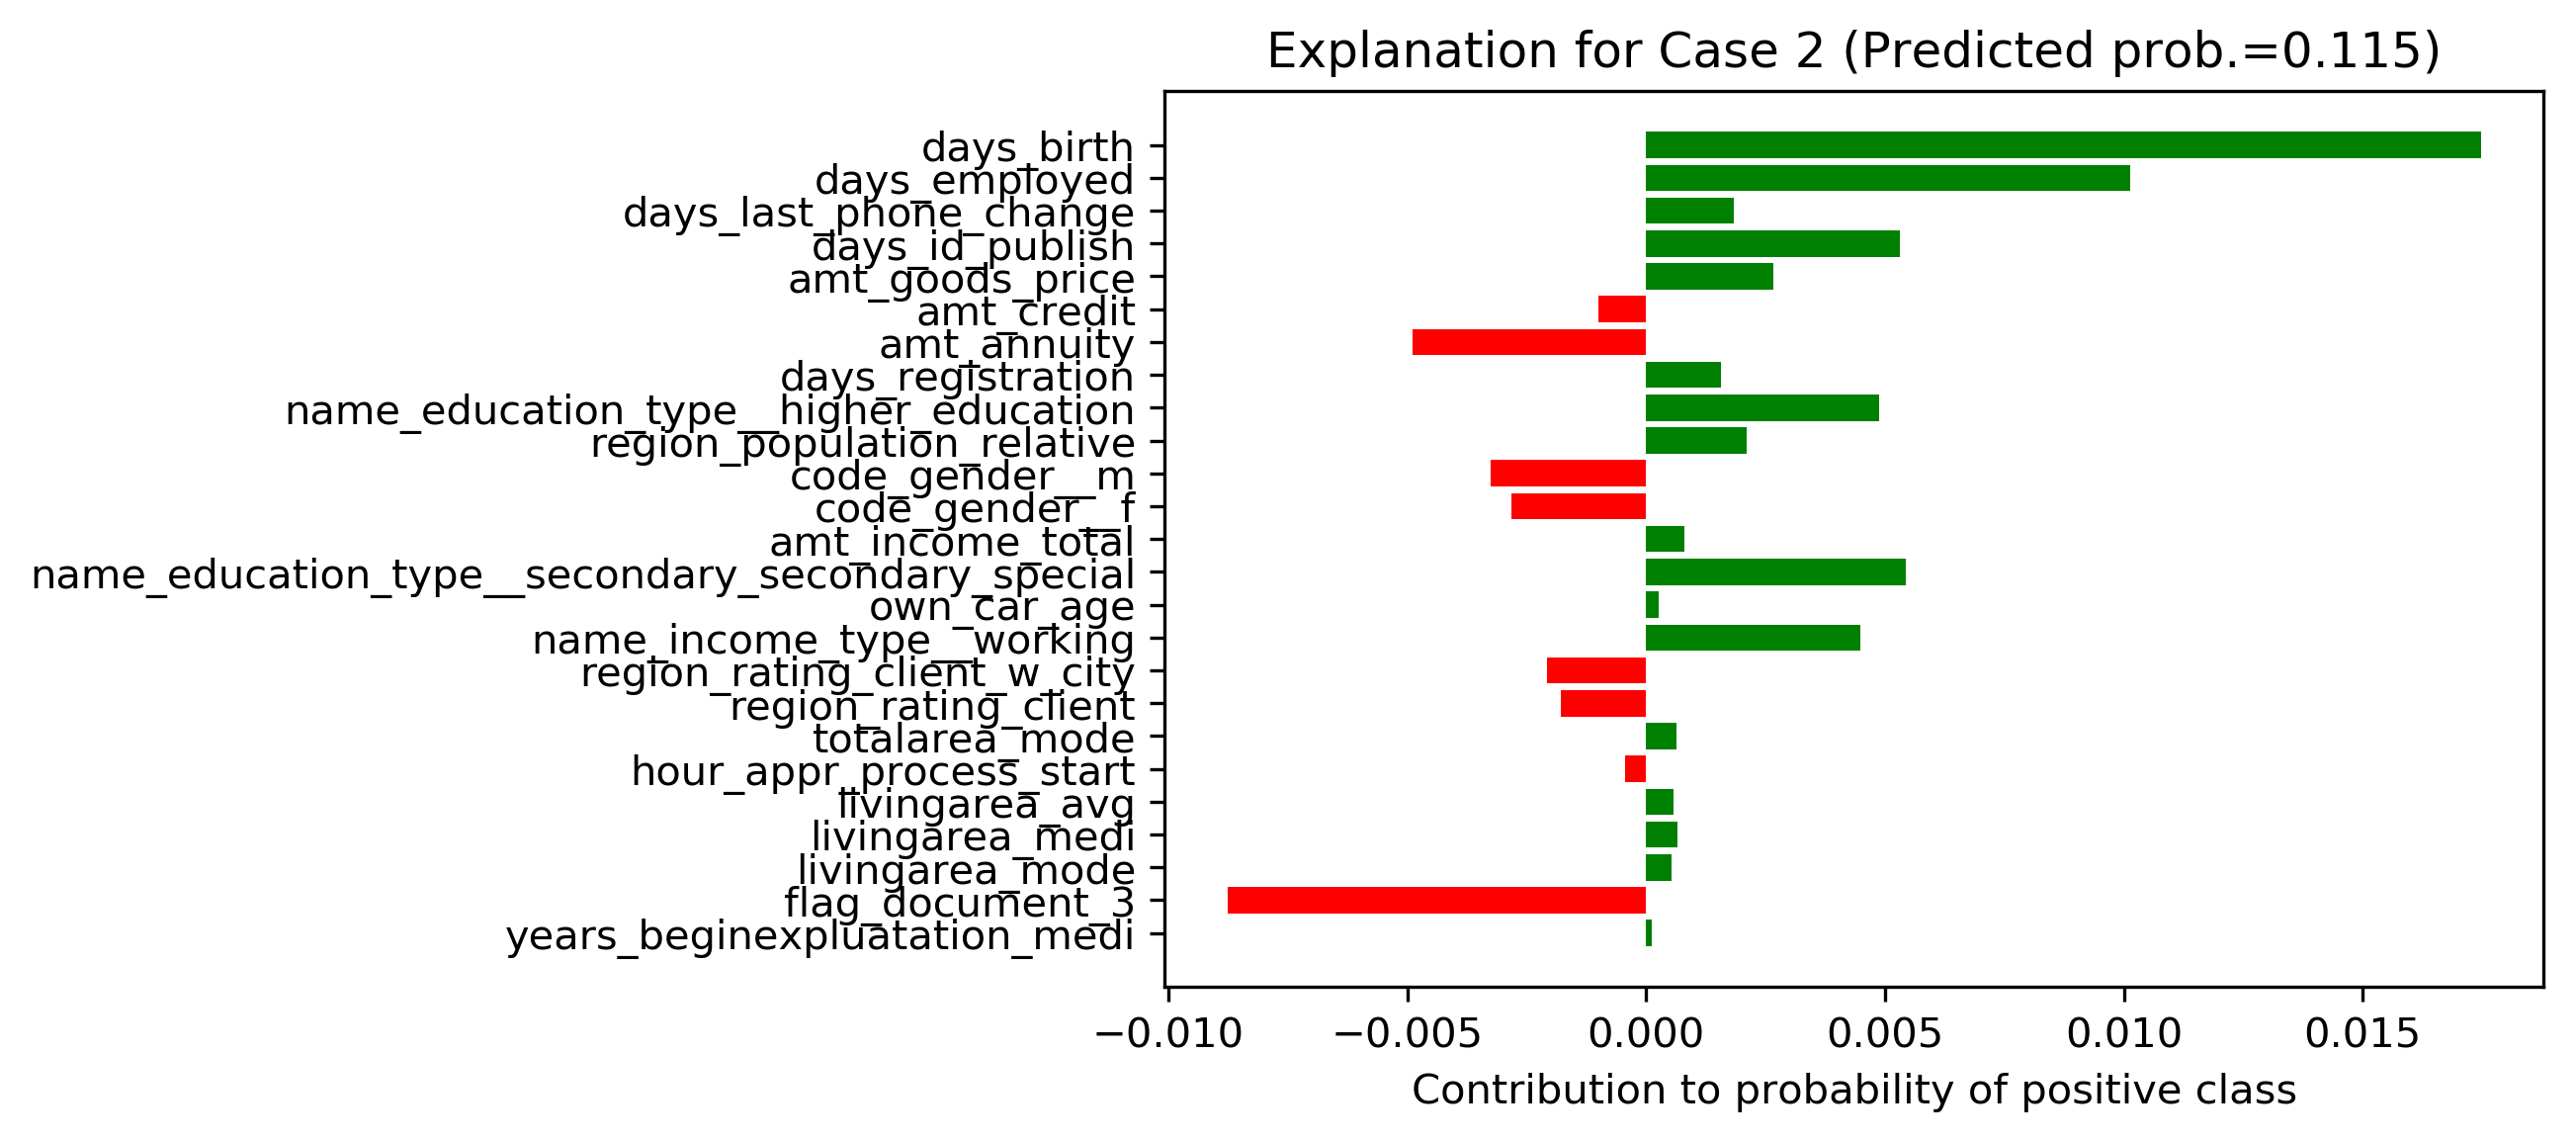

In [274]:
i =  2 # 98 # 147 #145 # 125 #296
_ = as_pyplot_figure( tc_exps[i][:25], p0, X_train.columns[:25], f'Case {i}')

In [251]:
import numpy as np

In [255]:
 (tc_exps.sum( axis=1)  + p0).shape, y_train.shape

((1000,), (246008,))

In [261]:
pred0 = tc_exps.sum( axis=1)  + p0
np.argmax( pred0 )

296

In [262]:
pred0[296]

0.24227905251369716

In [271]:

rfc1.predict_proba( X_train.iloc[[i], :]), y_train.iloc[i]

(array([[0.83733868, 0.16266132]]), 0)

In [268]:
for arr in np.vstack( [ range(1000), tc_exps.sum( axis=1)  + p0, y_train[:1000] ] ).transpose() : 
    print( arr )

[0.        0.1144148 0.       ]
[1.         0.04682238 0.        ]
[2.         0.10783017 1.        ]
[3.         0.03912963 0.        ]
[4.         0.03825541 0.        ]
[5.         0.05884773 0.        ]
[6.         0.13918099 0.        ]
[7.         0.10163822 0.        ]
[8.         0.05952999 0.        ]
[9.         0.05135524 0.        ]
[10.         0.0728551  0.       ]
[11.          0.10551851  1.        ]
[12.          0.07369306  0.        ]
[13.          0.12867246  0.        ]
[14.          0.09020546  1.        ]
[15.          0.07453772  0.        ]
[16.          0.04050638  0.        ]
[17.          0.09428407  0.        ]
[18.          0.04688526  0.        ]
[19.          0.04994455  0.        ]
[20.          0.03850953  0.        ]
[21.          0.08247124  0.        ]
[22.          0.06899801  0.        ]
[23.          0.04300207  0.        ]
[24.          0.04555208  0.        ]
[25.          0.04700289  0.        ]
[26.          0.05772683  0.        ]
[27.      